# Introduction to Molecular Dynamics

In classical molecular dynamics (MD), a simulation engine numerically integrates Newton's equations of motion to move particles through time.  The general process is similar to the previous simulation example of the ball falling from rest.  Since acceleration is the change in velocity over time, and velocity is the change in position over time, we can therefore evolve the position of particles in the system.  However,  instead of a constant acceleration due to gravity, acceleration results from the interaction between particles in the system following the relationship $F = ma$, where $F$ is the force, $m$ is the mass and $a$ is acceleration. 

Newton's equations represent a set of 'N' second order differential equations (where 'N' corresponds to the number of particles). There are many ways in which to perform the numerical integration, some better than others in terms of stability and precision. 

#### Velocity Verlet algorithm
This method is a commonly used, robust scheme, e.g., used in packages such [LAMMPS](http://lammps.sandia.gov).   The Velocity Verlet algorithm updates the position at time $t+\delta t$  based on the velocity ($\vec{v_i}$) and force at the current time $t$. 

$\vec{r_i}(t+\delta t) = \vec{r_i}(t) + \vec{v_i}(t)\delta t + \frac{1}{2m_i}\vec{F_i}(t)\delta t^2$ 

The velocity is updated using the following equation:

$\vec{v_i}(t+\delta t) = \vec{v_i}(t) + \frac{1}{2m_i}\left[\vec{F_i}(t)+\vec{F_i}(t+\delta t)\right]\delta t$ 

For more detail information see [David Kofke's lecture slides on the Velocity Verlet algorithm (and other integration methods).](https://www.eng.buffalo.edu/~kofke/ce530/Lectures/Lecture11/sld041.htm) 

#### Exercise
Modify the ball falling code (included below) to use the Velocity Verlet algorithm to update positions.  Here we will assume that the force acting on the ball follows $F=ma$ where we can assume the ball is of mass 'm' (note mass will cancel out in the equation, thus we do not actually need to define it). Also note, since this ball experiences a constant acceleration, the force is constant throughout time.  
* Use the ```height_array_vv``` to store the position for the Velocity Verlet algorithm and the ```velocity_array_vv``` to store the velocity for the Velocity Verlet algorithm. You can leave the other code in place for comparison.
* If you have done this correctly, the output plots on the right hand column (for Velocity Verlet) will be identical to the left hand column (using the kinematic equations). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


g = -9.8 #gravitation constant, m/s^2
dt = 0.0001 #timestep, s
timesteps  = 22000 #total number of timesteps to consider

velocity_i = 5.0 #initial velocity, m/s
height_i = 10.0 #initial height, m


velocity_array = np.zeros(timesteps)
height_array  = np.zeros(timesteps)

#arrays for the velocity verlet algorithm
height_array_vv = np.zeros(timesteps)
velocity_array_vv = np.zeros(timesteps)




time_array = np.zeros(timesteps)

height_array[0] = height_i
height_array_vv[0] = height_i

velocity_array[0] = velocity_i
velocity_array_vv[0] = velocity_i


current_height = height_i

for i in range (0, timesteps-1):
        
        time_array[i+1] = time_array[i] + dt
        velocity_array[i+1] = velocity_array[i] + (g*dt)
        height_array[i+1] = height_array[i]+ 0.5*(velocity_array[i]+velocity_array[i+1])*dt

        #add the velocity verlet code here
        height_array_vv[i+1] = 
        velocity_array_vv[i+1] = 
        
        #if we have reached the ground, zero out the position and velocity
        if height_array[i+1] <= 0:
            velocity_array[i+1] = 0
            height_array[i+1] = 0
            #velocity verlet arrays
            height_array_vv[i+1] = 0
            velocity_array_vv[i+1] = 0

ax = plt.subplot(2,2,1)
ax.plot(time_array, height_array, c='blue')
plt.ylabel('height (m)')


ax = plt.subplot(2,2,2)
ax.plot(time_array, height_array_vv, c='green')


ax = plt.subplot(2,2,3)
ax.plot(time_array, velocity_array, c='blue')
plt.ylabel('velocity (m/s)')
plt.xlabel('time (s)')



ax = plt.subplot(2,2,4)



ax.plot(time_array, velocity_array_vv, c='green')


plt.xlabel('time (s)')

plt.show()

### Interaction potential

As noted above, we can numerically integrate the motion of particles in a system if we know the forces that act upon them. Typically, we think about the forces acting upon particles through consideration of the interaction potential, $U$, where the force is defined to be the negative gradient of the interaction potential (i.e., $F = -\nabla U$ ).  

Classical molecular dynamics does not explicitly consider the electronic structure, instead capturing interactions between particles (i.e., $U$) via a set of analytical (or numerical) functions. 

#### Force fields
The interaction potentials between particles in the system are referred to as a "force field."  The force field is typically considered to have two main contributions, non-bonded and bonded:

$U_{total} = U_{non-bonded} + U_{bonded}$ 

For atomistically detailed systems (i.e., where we consider all atoms in the system explicitely) non-bonded interactions consist of a term to describe the van der Waals interactions and a term to descibe the electrostatic (or charge) interactions: 

$U_{non-bonded} = U_{van der Waals} + U_{charge}$

Bonded interactions describe any topological constraints meant to enforce a given structure in a molecule.  These included bonds between a pair of connected atoms, angles between three connected atoms, and dihedrals (or torsional) terms between 4 atoms (note dihedrals can take two forms, "proper" and "improper" as shown in the figure below):

$U_{bonded} = U_{bond} + U_{angle} + U_{dihedral}$

![Bonds, angles, dihedrals, and impropers, from http://www.mbnexplorer.com/users_guide_2.0/users_guide994x.png](img/bondangledihedral.png)

####  Example: the Optimized Potentials for Liquid Simulations (OPLS) forcefield:

In general, classical force fields tend to have similar functional forms (although, the subtle differences between force fields is quite important!).  As an example, consider the functional form of the commonly used OPLS force field:

$U_{van der waals} = 4\epsilon\left[ \left(\frac{\sigma}{r}\right)^{12}- \left(\frac{\sigma}{r}\right)^6 \right]$

$U_{charge} = \frac{q_iq_j e^2}{ r}$

$U_{bond} = K_r (r-r_0)^2$

$U_{angle} = k_\theta (\theta-\theta_0)^2$

$U_{dihedral} = \frac {V_1} {2} \left [ 1 + \cos (\phi-\phi_0) \right ]   + \frac {V_2} {2} \left [ 1 - \cos 2(\phi-\phi_0) \right ]
                + \frac {V_3} {2} \left [ 1 + \cos 3(\phi-\phi_0) \right ]
                + \frac {V_4} {2} \left [ 1 - \cos 4(\phi-\phi_0) \right ] $
                
Here, $r$ represents the separation between two atoms, $\theta$ the angle between 3 atoms, $\phi$ is between 4 atoms, $q_i$ is the charge on atom "i" and $q_j$ the charge on atom "j". The other variables (e.g., $\epsilon$, $\sigma$, $r_0$, etc.) are parameters used adjust the force field to match a given potential energy landscape.

#### Timescales of interactions

Given that an MD simulation numerically integrates the equations of motion through time, the simulation timestep is limited by the highest frequency vibration in the system. Recall in the example of the falling ball, if the timestep were too large we would miss the important features of the trajectory; the same general concept applies to MD simulations.  A general rule of thumb is that timestep should be ~1/10 the highest frequency.  Since C-H bond stretching tends to be the fastest mode ($10^{-14}$ s), a 1 fs timestep is often the limit for atomistic systems.  

Several methods have been developed to allow larger timesteps. For example, the SHAKE and RATTLE algorithms can be used to effectively keep bond distances fixed and eliminate this high frequency mode, typically allowing for a 2 fs timestep. 

The rRESPA multi-timescale integrator can also be used, where different timesteps are used for the different interactions (e.g., a smaller timestep for bonded interactions computed in an inner loop, larger timesteps for slower modes in an outer loop). 

### The Lennard-Jones (LJ) Potential

Let us focus on the $U_{van der waals}$ term in the OPLS forcefield, modeled using the 12-6 Lennard-Jones potential.  There are many ways the non-bonded van der Waals term can be expressed, although the 12-6 Lennard-Jones potential is the one of the most commonly used function forms.  

$U(r) = 4\epsilon\left[ \left(\frac{\sigma}{r}\right)^{12}- \left(\frac{\sigma}{r}\right)^6 \right]$

In the LJ equation there are two adjustable fitting parameters, $\epsilon$ which dictates the interaction strength, and $\sigma$ which dictates the size of the particle. Note, $r$ is the distance between two particles.

>- The short-range $1/r^{12}$ repulsion is used to model the overlap of electron clouds of the atoms. 

>- The longer-range $1/r^{6}$ attraction is used to model dispersion interactions.

>- The minimum of the potential occurs at $r = 2^{(1/6)}\sigma$


As previously noted, the force is the negative gradient of the potential. For the LJ equation, this becomes:

$F(r) =  \frac{48\epsilon}{\sigma}\left[ \left(\frac{\sigma}{r}\right)^{13}- \frac{1}{2}\left(\frac{\sigma}{r}\right)^7 \right]$

The LJ potential and force is plotted in the script below.

#### Exercise:
> Modify the ```epsilon``` and ```sigma``` variables in the script to see the effect on the potential and force.

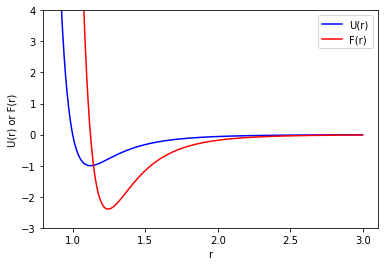

In [4]:
import numpy as np
import matplotlib.pyplot as plt


epsilon = 1.0
sigma = 1.0

r_min = 0.9
r_max = 3.0
steps = 1000
r_step = (r_max-r_min)/steps

U = np.zeros(steps)
F = np.zeros(steps)
r  = np.zeros(steps)
for i in range (0, steps):
        
        r[i] = r_min + r_step*i
        U[i] = 4*epsilon*((sigma/r[i])**12 - (sigma/r[i])**6)
        F[i] = 48*(epsilon/sigma)*((sigma/r[i])**13 - 0.5*(sigma/r[i])**7)

        
plt.plot(r, U, c='blue', label='U(r)')
plt.plot(r, F, c='red', label='F(r)')

plt.ylabel('U(r) or F(r)')
plt.xlabel('r')
plt.ylim(-3,4)
plt.legend(loc='upper right')

plt.show()

#### Alternative expressions
For the CHARMM forcefield, the LJ potential is often expressed as: 

$U(r) = \epsilon\left[ \left(\frac{r_m}{r}\right)^{12}- 2\left(\frac{r_m}{r}\right)^6 \right]$

where $r_m = 2^{(1/6)}\sigma$.  Substituting $r_m$ into the equation yields the same functional form as above.

The LJ potential is also sometimes written in the "AB" form:

$U(r) = \frac{A}{r^{12}} -\frac{B}{r^{6}}$

When $A=4\epsilon\sigma^{12}$ and $B= 4\epsilon\sigma^{6}$, we recover the standard 12-6 form. 

A more general "2n" form is also common, that resembles the CHARMM functional form, but allows for different exponents; when n=6, we recover the 12-6 form. 

$U(r) = \epsilon\left[ \left(\frac{r_m}{r}\right)^{2n}- 2\left(\frac{r_m}{r}\right)^n \right]$

Similarly, the Mie potential is another generalized form that reduces to the LJ potential when n = 12 and m = 6:

$U(r) = \left( \frac{n}{n-m}\right)\left(\frac{n}{m}\right)^{m/(n-m)}\epsilon\left[ \left(\frac{\sigma}{r}\right)^{n}- \left(\frac{\sigma}{r}\right)^m \right]$

#### Other expressions of the van der Waals interaction
While the $1/r^{12}$ term has been commonly used to model the repulsion of atoms, and is computationally convenient as it is a multiple of $1/r^{6}$, the Buckingham potential (often call the "exponential-6" or "exp-6" potential), is considered more accurate:

$U(r) = \gamma\left[ e^{-r/r_0}- \left(\frac{r_0}{r}\right)^6 \right]$

The COMPASS force field uses the 6/9 class2 LJ forcefield.  This puts the minimum of the potential at $\sigma$ rather than $2^{(1/6)}\sigma$:

$U(r) = \epsilon\left[ 2\left(\frac{\sigma}{r}\right)^{9}- 3\left(\frac{\sigma}{r}\right)^6 \right]$

#### Exercise:
> As a simple exercise, add to the LJ plotting code in order to plot: 
> - the Mie potential and see the effect of the exponents on the shape
> - the 6/9 class2 LJ potential.

## Simulation Conditions
### Periodic Boundary Conditions
Since, in most cases, MD simulations can only model a very small subset of a real physical system (on the order of nanometers), periodic boundary conditions are typically employed.  As a particle "leaves" a simulation box, it re-enters on the opposite side, resulting in an infinite, yet periodic system. This approach avoids artifacts associated with hard boundaries, although may itself introduce artifacts associated with periodicity if the system is too small.
Explicit self-interactions are not allowed; that is, you would not calculate the potential between a given particle and its periodic image. 

The image below on the left presents a cartoon representation of a system with its periodic images. A simple animation of periodic boundary conditiosn can be found at the follow [youtube link](https://www.youtube.com/watch?v=5qdNafdyaG0).


### Minimum Image Convention
MD simulations typically employ what is known as the "minimum image convention."  
> * For example, consider two particles (A and B) in a cubic simulation box of edge length 10.  Particle A is located at [1,0,0] and Particle B is located at [8,0,0].  The distance between the particles within the simulation box is therefore 7. However, the distance between Particle A and the periodic image of Particle B is actually 3.  Thus, with the minimum image convenction we would consider the distance between these two particles to be 3. 
> * In more algorithmic terms, if the distance between two particles is greater than half the box length, the length of the box is subtracted from the distance between the particles. 

A cartoon representation of the minimum image convention is shown below, right. In this example, the yellow particle interacts with the periodic image of the black particle, rather than the black particle within the same cell.

![2d cartoon of periodic images](img/pbc_min2.png)

#### Exercise
> Modify the ball falling example such that the particle is moving at a constant velocity (no gravitational acceleration) and change the code such that it implements periodic boundary conditions with walls at 10 and -10 in the height.
 * As another simple exercise, considering adding a small random perturbation (on the order of +/- 0.01) to the velocity at each timestep to see the effect.  Don't forget to set the seed! 
    * https://docs.python.org/3.6/library/random.html
    * Note that the floating point random number generate in Python returns values from 0.0 to 1.0.  To generate between -1.0 and 1.0 we need to make a very simple modification ```(2.0*random()-1.0)```. 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand

g = 0 #gravitation constant, m/s^2
dt = 0.001 #timestep, s
timesteps  = 100000 #total number of timesteps to consider

velocity_i = 1.0 #initial velocity, m/s
height_i = 0.0 #initial height, m

#boundaries of the system
height_min = -10
height_max = 10
height_length= height_max - height_min


velocity_array = np.zeros(timesteps)
height_array  = np.zeros(timesteps)

time_array = np.zeros(timesteps)

height_array[0] = height_i
velocity_array[0] = velocity_i

current_height = height_i



for i in range (0, timesteps-1):
        
        time_array[i+1] = time_array[i] + dt
        velocity_array[i+1] = velocity_array[i] + (g*dt)
        height_array[i+1] = height_array[i]+ 0.5*(velocity_array[i]+velocity_array[i+1])*dt

        #apply periodic boundary conditions to the system
        height_array[i+1] = 

ax = plt.subplot(2,1,1)
ax.plot(time_array, height_array, c='blue')

plt.ylabel('height (m)')

ax = plt.subplot(2,1,2)
ax.plot(time_array, velocity_array, c='red')
plt.ylabel('velocity (m/s)')

plt.xlabel('time (s)')

plt.show()

## Speeding things up 
### Cutoffs
You may notice that the LJ potential shown above, quickly starts approaching zero.  A way to reduce computational cost is to simply ignore any particles that are beyond a certain cutoff distance, typically denoted $r_c$.  The value of this cutoff (and how the potential is actually cutoff), will alter the results slightly. Long range corrections to the potential energy can be applied (e.g., that use a mean field approximation) that are able to closely approximate the "true" potential energy of the system.  Commonly employed cutoffs you will find in the literature: 

> $2.24\sigma$ 
> * The minimum of the LJ potential occurs at $2^{(1/6)}\sigma \sim 1.12\sigma$, thus this cutoff is twice the minimum.
> * However, this cutoff tends to only appear in older literature; the shorter cutoff was likely used as a means to speed up a simulation.

> $2.5\sigma$
> * This corresponds to a point where the potential is quite small, $<$ 1/60 of the strength of the maximum well depth.  This is quite common, especially for coarse-grained models.  

> 12 to 15 angstroms. 
> * Many atomistic force fields apply a single cutoff for all species and the cutoff is not modulated by the characteristic $\sigma$ of an atom. For reference, $\sigma$ for carbon is ~3.5 angstroms, making this cutoff about 3.4 to 4.3 times $\sigma$. In many cases, force field parameters have been optimized and validated using a specific cutoff value. Thus users should refer to the force field documentation/publications for the appropriate choice.  

It is often not desirable to simply truncate the potential. One approach is to shift the force field such that the value is zero at the cutoff and thus avoiding a discontinuity (shifting can be done to either the force or the potential).  Note, if the force field is shifted it will slightly alter the well-depth of the potential and result in subtle differences as compared to an unshifted force field. Other approaches, such as smoothing algorithms and switching functions that do not alter the well-depth, can also be used to handle cutoff interactions (e.g., see xplor shifting in HOOMD-Blue).  

### Neighborlists
While employing a cutoff will reduce the number of times the code must calculate the interaction potential, calculating the distance between all pairs of particles in the system is still costly.  To avoid this calculation, a neighborlist can be constructed that includes all particles within the cutoff + buffer (the buffer is often called the "skin"). The general idea is that the local environment of a particle changes rather slowly, and thus the same neighborlist can be applied multiple times before needing to be reconstructed.   

#### The frequency of reconstruction will depend on numerous factors:

How fast  the system is changing. 
> This is often a consequence of the phase, where, for example gas phases will change much more rapidly than dense fluids.  Similarly, temperature will play a role, where high temperature systems will have particles moving faster than low temperature. 

The size of the buffer/skin. 
> If this is set too small, the neighborlist will need to be rebuilt very frequently, if too large, the computational savings will be minimal as the list will contain a very large number of particles.   

Note, setting the parameters incorrectly for the neighborlist can result in interactions being missed and systems crashing. Simulation packages often include checks when the list is rebuilt, to identify cases where a particle may have moved "too much" (i.e., greater than the size of the skin) and thus interactions may have been missed. These are often referred to as "Dangerous Builds." This will be discussed in a later tutorial.

Often times, the frequency that a neighborlist is rebuilt can be set to occur at a set time interval, or be made dynamic (including an additional check that if any particle moves more than half the size of the buffer, the list should be rebuilt).  Various algorithms can be used for speeding up construction of the neighborlist (appropriateness depends on the application). Quoting from the HOOMD-Blue documentation (http://hoomd-blue.readthedocs.io/en/stable/module-md-nlist.html):  

```The simplest way to build a neighbor list is O(N^2): each particle loops over all other particles and only includes those within the neighbor list cutoff. This algorithm is no longer implemented in HOOMD-blue because it is slow and inefficient. Instead, three accelerated algorithms based on cell lists and bounding volume hierarchy trees are implemented. The cell list implementation is fastest when the cutoff radius is similar between all pair forces (smaller than 2:1 ratio). The stencil implementation is a different variant of the cell list, and is usually fastest when there is large disparity in the pair cutoff radius and a high number fraction of particles with the bigger cutoff (at least 30%). The tree implementation is faster when there is large size disparity and the number fraction of big objects is low. Because the performance of these algorithms depends sensitively on your system and hardware, you should carefully test which option is fastest for your simulation.```


# Common Ensembles

If we were to simply implement the Velocity Verlet algorithm above, we would sample the microcanonical ensemble (i.e., energy is fixed, but temperature will change). 
> However, in most cases it is more relevant to consider systems at constant temperature, necessitating the use of a thermostat to control the temperature. 

> In many cases it is also useful to allow system volume to change for a constant temperature system, such that a system acheives a target pressure; this is accomplished through the use of a barostat.  
>   * Barostats can have their dimensions coupled (i.e., x,y, and z all increase or decrease uniformly), being entire isotropic (i.e., each direction changes independently based on the pressure tensor) or some combination (e.g., coupling x and y but not z). 


#### Microcanonical (NVE)
Constant: number of particles (N), volume (V), and energy (E) 
#### Canonical (NVT)
Constant: number of particles (N), volume (V), and temperature (T)
#### Isothermal-isobaric (NPT)
Constant: number of particles (N), pressure (P), and temperature (T)


